In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tqdm import tqdm
import simpleaudio as sa


In [2]:
tf.config.list_physical_devices('GPU')
import os
from os.path import join as pjoin
import simpleaudio as sa
from scipy.io import wavfile


original_data_dir = pjoin(os.getcwd(),"../AudioFiles","wavs")
compressed_data_dir = pjoin(os.getcwd(),"../AudioFiles","medio")
original_fname = pjoin(original_data_dir, '55_tdcast.wav')
compressed_fname = pjoin(compressed_data_dir, '55_tdcast.wav')

samplerate_original, original_data = wavfile.read(original_fname)
print(f"number of channels = {original_data.shape[1]}")

length = original_data.shape[0] / samplerate_original
print(f"length = {length}s")

samplerate_compressed, compressed_data = wavfile.read(compressed_fname)

number of channels = 2
length = 1379.4220408163264s


<ipython-input-2-8920eedfbf61>:19: WavFileWarning: Chunk (non-data) not understood, skipping it.
  samplerate_compressed, compressed_data = wavfile.read(compressed_fname)


In [3]:
compressed_data = np.array(compressed_data[:,0].reshape(-1,1))
original_data = np.array(original_data[:,0].reshape(-1,1))

In [4]:

play_obj = sa.play_buffer(compressed_data, 1, 2, samplerate_original)
#play_obj.wait_done()

In [8]:
play_obj.stop()

In [6]:
seq = original_data[:samplerate_original*5]
volume = .3
normalization = 32767 / np.max(np.abs(seq))
audio = (seq[:,0].reshape(-1)*normalization*volume).astype(np.int16)
play_obj = sa.play_buffer(audio, 1, 2, samplerate_original)

In [7]:
len(compressed_data) - len(original_data)

0

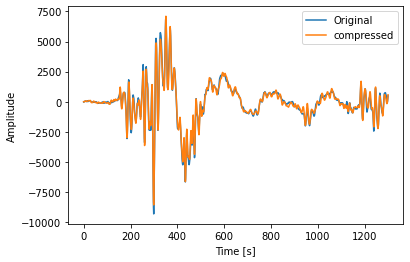

In [9]:
import matplotlib.pyplot as plt
import numpy as np
# time = np.linspace(0., 10000, data.shape[0])
plt.plot(original_data[10700:12000, 0], label="Original")
plt.plot(compressed_data[10700:12000, 0], label="compressed")
plt.legend()
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.show()

In [100]:
samplesize = 50
clean_audio = original_data[:5000000]
dirty_audio = compressed_data[:5000000]

In [101]:
def getSamplesFromFile(file, samplesize):
    n_chunks = len(file)//samplesize
    return file[:n_chunks*samplesize].reshape(-1,samplesize,1)

def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

In [102]:
y = getSamplesFromFile(clean_audio, samplesize)
x = getSamplesFromFile(dirty_audio, samplesize)
val_start = int(len(x)*.9)
X_train,X_valid = x[:val_start],x[val_start:]
Y_train,Y_valid = y[:val_start],y[val_start:]

In [103]:
X_train.shape

(90000, 50, 1)

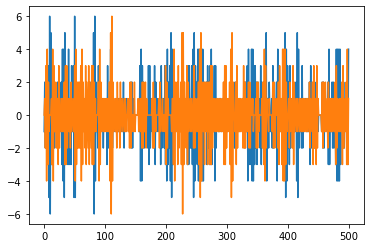

In [104]:
plt.plot(X_train[0:10].reshape(-1))
plt.plot(Y_train[0:10].reshape(-1))
plt.show()

In [105]:
input_ = keras.layers.Input(shape=X_train.shape[1:])

hidden1 = keras.layers.Conv1D(filters=64, kernel_size=3, padding='same', activation='relu')(input_)
hidden2 = keras.layers.MaxPooling1D(pool_size=2, padding='same')(hidden1)
hidden3 = keras.layers.Conv1D(filters=128, kernel_size=3, padding='same', activation='relu')(hidden2)
hidden4 = keras.layers.UpSampling1D(size=2)(hidden3)

lay = keras.layers.Dense(128)(hidden4)
lay = keras.layers.BatchNormalization()(lay)
lay = keras.layers.Dropout(0.2)(lay)
output = keras.layers.Dense(1)(lay)

model = keras.models.Model(inputs=[input_], outputs=[output])

In [39]:
input_ = keras.layers.Input(shape=X_train.shape[1:])


lay = keras.layers.Flatten()(input_)
lay = keras.layers.BatchNormalization()(lay)
lay = keras.layers.Dropout(0.2)(lay)
output = keras.layers.Dense(X_train.shape[1])(lay)

model = keras.models.Model(inputs=[input_], outputs=[output])

In [106]:
model.summary()

Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(None, 50, 1)]           0         
_________________________________________________________________
conv1d_18 (Conv1D)           (None, 50, 64)            256       
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 25, 64)            0         
_________________________________________________________________
conv1d_19 (Conv1D)           (None, 25, 128)           24704     
_________________________________________________________________
up_sampling1d_9 (UpSampling1 (None, 50, 128)           0         
_________________________________________________________________
dense_28 (Dense)             (None, 50, 128)           16512     
_________________________________________________________________
batch_normalization_18 (Batc (None, 50, 128)           512

In [107]:
model.compile(loss="mse", optimizer=keras.optimizers.Adam(lr=0.01))
history = model.fit(X_train, Y_train, epochs=20, batch_size=256,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
352/352 [==============================] - 3s 9ms/step - loss: 10272028.0000 - val_loss: 469028.4688
Epoch 2/20
352/352 [==============================] - 3s 8ms/step - loss: 887662.0625 - val_loss: 538816.5000
Epoch 3/20
352/352 [==============================] - 3s 8ms/step - loss: 694107.3750 - val_loss: 449184.4062
Epoch 4/20
352/352 [==============================] - 3s 8ms/step - loss: 702469.6875 - val_loss: 406810.9688
Epoch 5/20
352/352 [==============================] - 3s 8ms/step - loss: 703829.5625 - val_loss: 405104.1875
Epoch 6/20
352/352 [==============================] - 3s 8ms/step - loss: 707864.6250 - val_loss: 376334.8438
Epoch 7/20
352/352 [==============================] - 3s 8ms/step - loss: 703266.7500 - val_loss: 403958.6250
Epoch 8/20
352/352 [==============================] - 3s 8ms/step - loss: 705962.7500 - val_loss: 373831.2812
Epoch 9/20
352/352 [==============================] - 3s 8ms/step - loss: 700724.6875 - val_loss: 404262.0625
Epoch 10

In [ ]:
#4928491.5000
#1496164.2500
#2036409.7500 
#Colocar result de 1 densa no relatorio
#Treinar com seq inteira 

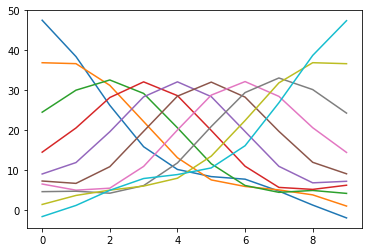

In [43]:
_ = plt.plot(model.layers[4].weights[0].numpy())

In [108]:
predicted = model.predict(X_valid)

In [109]:
predicted.shape

(10000, 50, 1)

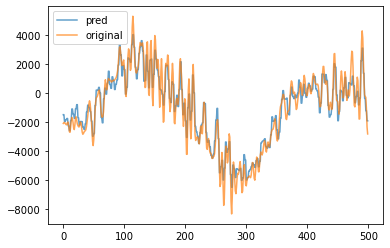

In [110]:
plt.plot(predicted[0:10].reshape(-1), label="pred", alpha=.7)
plt.plot(Y_valid[0:10].reshape(-1), label="original", alpha=.7)
plt.legend()
plt.show()

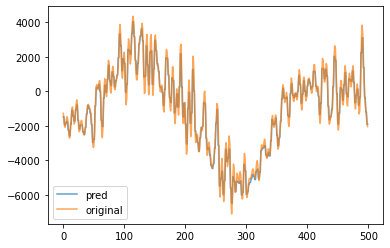

In [115]:
plt.plot(predicted[0:10].reshape(-1), label="pred", alpha=.7)
plt.plot(X_valid[0:10].reshape(-1), label="original", alpha=.7)
plt.legend()
plt.show()

In [78]:
predicted = model.predict(X_train)

In [79]:
X_train.shape

(450000, 10, 1)

In [31]:
def play_seq(seq, volume):
    normalization = 32767 / np.max(np.abs(seq))
    audio = (seq.reshape(-1)*normalization*volume).astype(np.int16)
    play_obj = sa.play_buffer(audio, 1, 2, samplerate_original)
    return play_obj

In [111]:
x = play_seq(X_valid, 1) #Comprimido

In [112]:
x.stop()

In [113]:
x = play_seq(predicted, 1) #Predito

In [114]:
x.stop()

In [98]:
x= play_seq(Y_valid, .8) #Oliginal

In [99]:
x.stop()

In [170]:
def save_seq(name,seq, volume, samplerate):
    normalization = 32767 / np.max(np.abs(seq))
    audio = (seq.reshape(-1)*normalization*volume).astype(np.int16)
    wavfile.write(name,samplerate*2,audio)

In [186]:
save_seq("predicted.wav", predicted, .5, samplerate)
save_seq("shouldbe.wav", Y_train, 1, samplerate)
save_seq("itwas.wav", X_train, 1, samplerate)

In [163]:
predicted.shape

(90000, 10, 1)